# Scraping de les webs dels principals partits polítics espanyols per obtenir els seus discursos.

Prenent com a model aquest <a href="http://www.nytimes.com/interactive/2012/09/06/us/politics/convention-word-counts.html?_r=0">artícle</a> on s'analitzen els discursos de demòcrates i republicans a les eleccions dels EUA de 2012 intentem fer un primer projecte que serveix com a exercici per establir les passes per fer un projecte similar en el context polític espanyol.

En aquest notebook obtenim els discursos penjats a les webs dels principals partits polítics de l'actualitat (2015): Partido Popular (PP), Partido Socialista Obrero Español (PSOE) y Podemos. Malauradament, aquesta tasca només va servir per adornar-nos que no disposem de prou dades per fer una comparació satisfatòria.

# Scraping

In [2]:
# Webs de documents dels partits polítics:

# PP
# http://www.pp.es/actualidad/documentos?page=1

# PSOE
# http://www.psoe.es/ambito/saladeprensa/docs/index.do?spaceId=3753&apt=4182&apt=4182&apt=4182&pagina=3

# Podemos
# http://podemos.info/prensa/ante-las-acusaciones-publicadas-por-el-mundo-el-30062014/
    
# Ciudadanos
# http://www.ciudadanos-cs.org/prensa#p=1&n=10

# Izquierda Unida
# http://www.izquierda-unida.es/documentos?page=1

# http://scrapy.org/
# https://media.readthedocs.org/pdf/scrapy/0.24/scrapy.pdf

### Mètodes i utilitats

In [3]:
from urllib2 import Request, urlopen, URLError

# Mètode per obtenir una pàgina web
def get_html_page(url_page):
    req = Request(url_page)
    try:
        html_page = urlopen(req)
    except URLError as e:
        if hasattr(e, 'reason'):
            print 'We failed to reach a server. URL: ' + url_page
            print 'Reason: ', e.reason
        elif hasattr(e, 'code'):
            print 'The server couldn\'t fulfill the request. URL: ' + url_page
            print 'Error code: ', e.code
    else:
        # everything is fine
        return html_page    

In [4]:
# http://stackoverflow.com/questions/7100125/storing-python-dictionaries

import json

# Mètodes per grabar y carregar fitxers en format json
def save_dict_json(dict, filename):
    with open(filename, 'wb') as fp:
        json.dump(dict, fp)

def load_dict_json(filename):
    with open(filename, 'rb') as fp:
        return json.load(fp)
    
# Mètode per grabar un fitxer de texte
def save_text_file(text, file_name, encoding = 'utf8'):
    with open(file_name, "w") as text_file:
        text_file.write(text.encode(encoding))
        
# Mètode per eliminar caracters incorrectes als noms de fitxers (potser millor utilitzar: https://pypi.python.org/pypi/goldfinch/0.4)
invalid_filename_chars_windows = '\/:*?"<>|'
def del_invalid_chars(value, deletechars):
    for c in deletechars:
        value = value.replace(c,'')
    return value;

In [5]:
# http://stackoverflow.com/questions/22676/how-do-i-download-a-file-over-http-using-python/22776#22776
# http://blog.radevic.com/2012/07/python-download-url-to-file-with.html

import urllib2
import sys

# Mètode per descarregar fitxers d'una url
def download_file(url, file_name, path = "", verbose = False):
    u = urllib2.urlopen(url)
    f = open(path+file_name, 'wb')
    meta = u.info()
    file_size = int(meta.getheaders("Content-Length")[0])
    if verbose:
        print("Downloading: {0} Bytes: {1}".format(url, file_size))

    file_size_dl = 0
    block_sz = 8192
    while True:
        buffer = u.read(block_sz)
        if not buffer:
            break

        file_size_dl += len(buffer)
        f.write(buffer)
        
        if verbose:
            p = float(file_size_dl) / file_size
            status = "\r{0} bytes  [{1:.2%}]".format(file_size_dl, p)
            status = status + chr(8)*(len(status)+1)
            sys.stdout.write(status)
            sys.stdout.flush()

            # done = int(50 * file_size_dl / file_size)
            # sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
            # sys.stdout.flush()

    f.close()
    print("\n")

# url = 'http://www.pp.es/sites/default/files/documentos/pr_den_2015.pdf'
# file_name = url.split('/')[-1]    
# download_file(url, file_name,'../data/pp/')

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import collections

# Mètode per dibuixar un diagrama de barres amb les freqüències dels documents per dies
def plot_doc_freq_bar_chart(loaded_doc_dict, barcolor, xticks_freq = 30, yticks_freq = 1):
    
    # Group docs by date
    doc_dict_group_by_date = {}
    for key in loaded_doc_dict:
        date = datetime.datetime.strptime(loaded_doc_dict[key]['date'], "%d/%m/%Y")
        if date in doc_dict_group_by_date:
            doc_dict_group_by_date[date].update({key:{'url':loaded_doc_dict[key]['url'],'name':loaded_doc_dict[key]['name']}})
        else:
            doc_dict_group_by_date[date] = {key:{'url':loaded_doc_dict[key]['url'],'name':loaded_doc_dict[key]['name']}}
    # print doc_dict_group_by_date

    doc_dict_group_by_date_ord = collections.OrderedDict(sorted(doc_dict_group_by_date.items(), reverse=False))
    # print doc_dict_group_by_date_ord

    # Dictionary with all days freq. doc
    base = datetime.datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)
    numdays = (base-next(iter(doc_dict_group_by_date_ord))).days
    # print "Desde:", base, ", fins:", next(iter(doc_dict_group_by_date_ord)), ", dies:", numdays

    date_list = [base - datetime.timedelta(days=x) for x in range(0, numdays)]

    all_days_dict = collections.OrderedDict(zip(date_list, [0]*len(date_list)))
    # print all_days_dict

    for key in doc_dict_group_by_date:
        if key in all_days_dict:
            all_days_dict[key]=len(doc_dict_group_by_date[key].items())

    # for key in all_days_dict:
    #    if all_days_dict[key] > 0:
    #        print "Date:", key, "Num. docs:", all_days_dict[key] 

    
    # Plot frequency bar chart Num. docs / day

    # Get xticks month labels 
    i = 0
    xticks_labels = []
    for key in all_days_dict:
        if i % xticks_freq == 0:
            xticks_labels.append(key.strftime("%b %Y"))
        i+=1
    # print xticks_labels

    # Get yticks num. docs labels
    yticks_labels = []
    for i in range(0,max(all_days_dict.values())+1):
        if i % yticks_freq == 0:
            yticks_labels.append(str(i))
    # print yticks_labels

    # Start plot
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5,10.5)
    # fig.subplots_adjust(left  = 0.0, right = 1.0, bottom = 0.0, top = 1.0, wspace = 0.0, hspace = 0.0)
    fig.canvas.draw()

    plt.bar(range(len(all_days_dict)), all_days_dict.values(), color = barcolor, align='center')
    plt.xticks(np.arange(0, len(all_days_dict), xticks_freq))
    plt.yticks(np.arange(0, max(all_days_dict.values())+1, yticks_freq))
    # plt.grid(True)

    ax.set_xticklabels(xticks_labels, rotation='vertical')
    ax.set_yticklabels(yticks_labels)
    
    plt.show()

#### Estructura dels diccionaris de documents

In [15]:
'''
document_dictionary = {
    <num_doc> : {
        'party' : <'PP', 'PSOE', 'Podemos'>,
        'date': <data del document>,
        'url': <url del document>,
        'type': <'html','pdf'>,
        'file': <<path + filename> on s'ha descarregat el document. Si és buit el document no s'ha descarregat encara.>,
        'content': <contingut del document en format texte>
        'updated': <data d'actualització del camp 'content'>
    }
}
'''

"\ndocument_dictionary = {\n    <num_doc> : {\n        'party' : <'PP', 'PSOE', 'Podemos'>,\n        'date': <data del document>,\n        'url': <url del document>,\n        'type': <'html','pdf'>,\n        'file': <<path + filename> on s'ha descarregat el document. Si \xc3\xa9s buit el document no s'ha descarregat encara.>,\n        'content': <contingut del document en format texte>\n        'updated': <data d'actualitzaci\xc3\xb3 del camp 'content'>\n    }\n}\n"

### Scraping de la web de documents del PP

In [7]:
# PP

# http://stackoverflow.com/questions/3075550/how-can-i-get-href-links-from-html-code
# http://stackoverflow.com/questions/12451997/beautifulsoup-gettext-from-between-p-not-picking-up-subsequent-paragraphs
# http://stackoverflow.com/questions/23380171/using-beautifulsoup-extract-text-without-tags
# http://www.crummy.com/software/BeautifulSoup/bs4/doc/#find-all-next-and-find-next

from bs4 import BeautifulSoup
import re
import time

t_init = time.clock()

pp_url = "http://www.pp.es/actualidad/documentos"
continue_scraping = True
web_page = 0
prev_num_doc = 1
num_doc = 1
pp_doc_dict = {}

while continue_scraping :
    url_page = pp_url + "?page={}".format(web_page)
    html_page = get_html_page(url_page)
    if html_page is not None:
        print "Parsing: " + url_page
        soup = BeautifulSoup(html_page)
    else:
        break
    
    prev_num_doc = num_doc
    pp_doc_dict_page = {}
    for div in soup.findAll('div', {'class' : 'info_doc_listed'}):
        time_tag = div.find_next("time")
        link_tag = div.find_next("a",attrs={'href': re.compile(".pdf$")})
        pp_doc_dict_page[num_doc] = {'party':'PP', 'date':time_tag.getText(), 'url':link_tag.get('href'), 'name':link_tag.getText(), 'type':'pdf', 'file':''}
        # print num_doc, ": ", pp_doc_dict_page[num_doc] 
        num_doc+=1
    
    # If page documents was already in the dictionary stop the scraping, otherwise add page documents
    if (prev_num_doc> 1 and pp_doc_dict[prev_num_doc-1]['url']==pp_doc_dict_page[num_doc-1]['url']):
        continue_scraping = False
        print "Scrap finished."
    else:
        pp_doc_dict.update(pp_doc_dict_page)
    
    #
    web_page+=1
    
    # if (web_page > 2):
    if (web_page > 200):
        continue_scraping = False

t_end = time.clock()
print "Parse finished in {0:.2f} seconds".format(t_end-t_init)
print "Saving docs dictionary..."
save_dict_json(pp_doc_dict, 'pp_doc_dict.json')
print "Number of Documents: {}".format(len(pp_doc_dict))    

Parsing: http://www.pp.es/actualidad/documentos?page=0
Parsing: http://www.pp.es/actualidad/documentos?page=1
Parsing: http://www.pp.es/actualidad/documentos?page=2
Parsing: http://www.pp.es/actualidad/documentos?page=3
Parsing: http://www.pp.es/actualidad/documentos?page=4
Parsing: http://www.pp.es/actualidad/documentos?page=5
Parsing: http://www.pp.es/actualidad/documentos?page=6
Parsing: http://www.pp.es/actualidad/documentos?page=7
Parsing: http://www.pp.es/actualidad/documentos?page=8
Parsing: http://www.pp.es/actualidad/documentos?page=9
Parsing: http://www.pp.es/actualidad/documentos?page=10
Parsing: http://www.pp.es/actualidad/documentos?page=11
Parsing: http://www.pp.es/actualidad/documentos?page=12
Parsing: http://www.pp.es/actualidad/documentos?page=13
Parsing: http://www.pp.es/actualidad/documentos?page=14
Parsing: http://www.pp.es/actualidad/documentos?page=15
Parsing: http://www.pp.es/actualidad/documentos?page=16
Parsing: http://www.pp.es/actualidad/documentos?page=17
Pa

In [8]:
pp_loaded_doc_dict = load_dict_json('pp_doc_dict.json')
# print pp_loaded_doc_dict

#### Bar Chart del número de documents al llarg del temps (docs "scraped" de la web del PP)

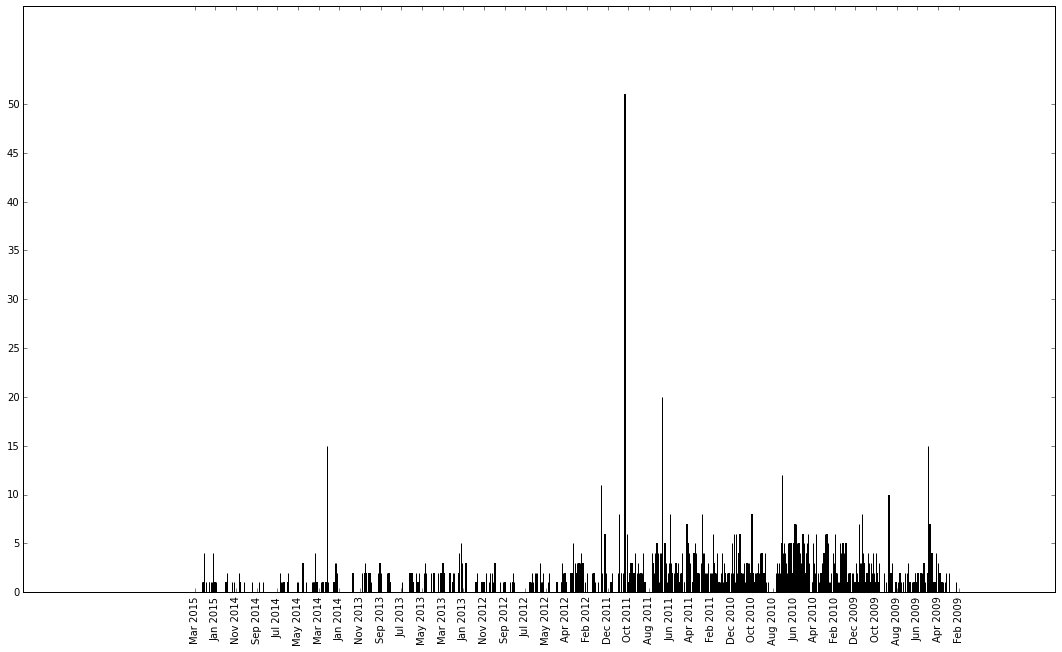

In [30]:
plot_doc_freq_bar_chart(pp_loaded_doc_dict, 'blue', xticks_freq = 60, yticks_freq = 5)

In [ ]:
# Mètode per descarregar els documents del diccionari de docs del PP
def download_pp_docs(pp_doc_dict, path="", overwrite = False):
    for key in pp_doc_dict:
        if pp_doc_dict[key]['file']=="" or overwrite:
            if pp_doc_dict[key]['type'] == 'html':
                html_page = get_html_page(pp_doc_dict[key]['url'])
                print "Saving: ", pp_doc_dict[key]['url']
                file_name = pp_doc_dict[key]['name'] + '.html'
                save_text_file(html_page, path + file_name)
                pp_doc_dict[key]['file'] = path + file_name
            elif pp_doc_dict[key]['type'] == 'pdf':
                print "Saving: ", pp_doc_dict[key]['url']
                file_name = pp_doc_dict[key]['url'].split('/')[-1]
                download_file(pp_doc_dict[key]['url'], file_name, path)
                pp_doc_dict[key]['file'] = path + file_name
            else:
                print "Unknown file type to download:", pp_doc_dict[key]['type']
    
    print "Updating 'pp_doc_dict'..."            
    save_dict_json(pp_doc_dict, 'pp_doc_dict.json')
            
download_pp_docs(pp_loaded_doc_dict, '../data/pp/')

### Scraping de la web de documents del PSOE

In [7]:
# PSOE

from bs4 import BeautifulSoup
import re
import time

t_init = time.clock()

psoe_url = "http://www.psoe.es"
psoe_url_docs = psoe_url + "/ambito/saladeprensa/docs/index.do?spaceId=3753&apt=4182&apt=4182&apt=4182"
continue_scraping = True
web_page = 1
prev_num_doc = 1
num_doc = 1
psoe_doc_dict = {}

while continue_scraping :
    url_page = psoe_url_docs + "&pagina={}".format(web_page)

    html_page = get_html_page(url_page)
    if html_page is not None:
        print "Parsing: " + url_page
        soup = BeautifulSoup(html_page)
    else:
        break
    
    prev_num_doc = num_doc
    psoe_doc_dict_page = {}
    for div in soup.findAll('div', {'class' : 'cajita'}):
        link = div.find_next("a", attrs={'href': re.compile("^/saladeprensa")})
        url_page = psoe_url + link.get('href')
        
        html_page = get_html_page(url_page)
        if html_page is not None:
            print "\tParsing: " + url_page
            soup = BeautifulSoup(html_page)
        else:
            break
        
        div_col_cuerpo = soup.find('div', {'class' : 'col-cuerpo'})
        link_pdf = div_col_cuerpo.find("a",attrs={'href': re.compile(".pdf$")})
        title_h2 = div_col_cuerpo.find("h2")
        div_fecha = div_col_cuerpo.find('div', {'class' : 'fecha'})
        strFecha = div_fecha.getText().strip()
        try:
            dtDate = datetime.datetime.strptime(strFecha, "%d/%m/%y")
        except ValueError as e:
            print e, "\ndtDate: ", dtDate
            continue
        strFecha = dtDate.strftime("%d/%m/%Y")
        if link_pdf :
            psoe_doc_dict_page[num_doc] = {'party':'PSOE', 'date':strFecha, 'url':psoe_url+link_pdf.get('href'), 'name':title_h2.getText().strip(), 'type':'pdf', 'file':''}
        else:
            psoe_doc_dict_page[num_doc] = {'party':'PSOE', 'date':strFecha, 'url':url_page, 'name':title_h2.getText().strip(), 'type':'html', 'file':''}
        # print num_doc, ": ", psoe_doc_dict_page[num_doc] 
        num_doc+=1
                            
    # If page documents was already in the dictionary stop the scraping, otherwise add page documents
    if (prev_num_doc> 1 and (prev_num_doc == num_doc or psoe_doc_dict[prev_num_doc-1]['url']==psoe_doc_dict_page[num_doc-1]['url'])):
        continue_scraping = False
        print "Scrap finished."
    else:
        psoe_doc_dict.update(psoe_doc_dict_page)
    
    #
    web_page+=1
    
    #
    if (web_page > 30):
        continue_scraping = False

t_end = time.clock()
print "Parse finished in {0:.2f} seconds".format(t_end-t_init)
print "Saving docs dictionary..."
save_dict_json(psoe_doc_dict, 'psoe_doc_dict.json')
print "Number of Documents: {}".format(len(psoe_doc_dict))  

Parsing: http://www.psoe.es/ambito/saladeprensa/docs/index.do?spaceId=3753&apt=4182&apt=4182&apt=4182&pagina=1
	Parsing: http://www.psoe.es/saladeprensa/docs/773925/page/manifiesto-dia-internacional-la-mujer.html
	Parsing: http://www.psoe.es/saladeprensa/docs/772868/page/manifiesto-psoe-dia-mundial-las-enfermaedades-raras.html
	Parsing: http://www.psoe.es/saladeprensa/docs/770762/page/tres-anos-la-reforma-laboral-del-100215.html
	Parsing: http://www.psoe.es/saladeprensa/docs/766092/page/intervencion-pedro-sanchez-el-plenario-del-grupo-parlamentario-socialista.html
	Parsing: http://www.psoe.es/saladeprensa/docs/761930/page/manifiesto-dia-la-constitucion.html
	Parsing: http://www.psoe.es/saladeprensa/docs/761266/page/intervencion-pedro-sanchez-el-foro-cinco-dias.html
Parsing: http://www.psoe.es/ambito/saladeprensa/docs/index.do?spaceId=3753&apt=4182&apt=4182&apt=4182&pagina=2
	Parsing: http://www.psoe.es/saladeprensa/docs/760214/page/manifiesto-del-psoe-por-dia-internacional-contra-viole

In [8]:
psoe_loaded_doc_dict = load_dict_json('psoe_doc_dict.json')
# print psoe_loaded_doc_dict

#### Bar Chart del número de documents al llarg del temps (docs "scraped" de la web del PSOE)

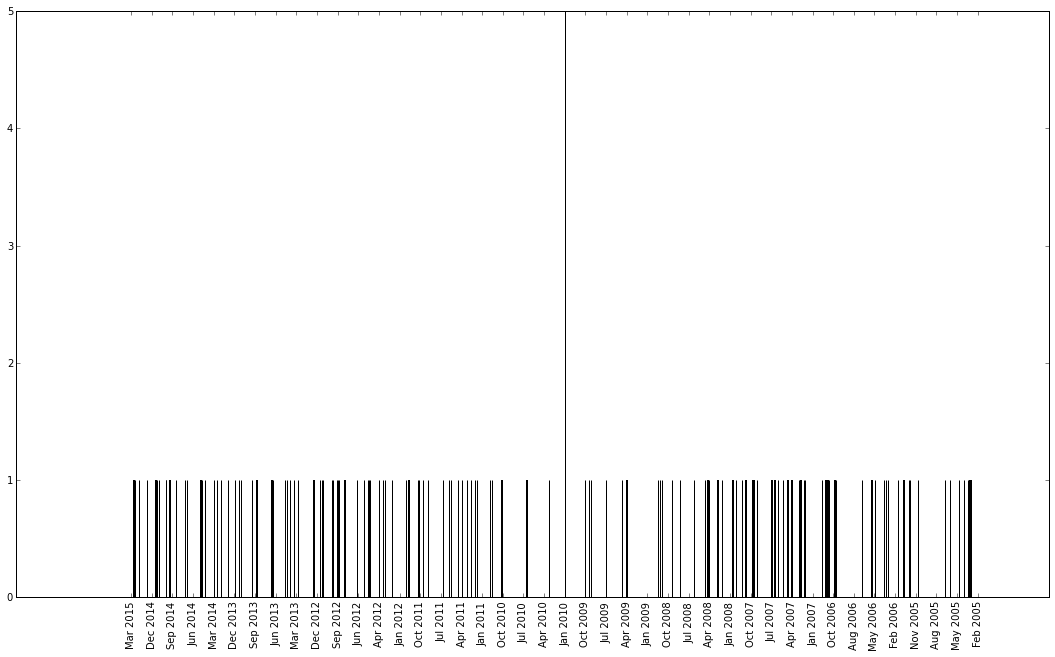

In [9]:
plot_doc_freq_bar_chart(psoe_loaded_doc_dict, 'red', xticks_freq = 90)

In [ ]:
# Mètode per descarregar els documents del diccionari de docs del PSOE
def download_psoe_docs(psoe_doc_dict, path="", overwrite = False):
    for key in psoe_doc_dict:
        if psoe_doc_dict[key]['file']=="" or overwrite:
            if psoe_doc_dict[key]['type'] == 'html':
                html_page = get_html_page(psoe_doc_dict[key]['url'])
                if html_page:
                    print "Parsing: " + url_page
                else:
                    continue

                soup = BeautifulSoup(html_page)
                div_body_detall = soup.find('div', {'class' : 'body_detall'})
                if div_body_detall:
                    print "Saving: ", psoe_doc_dict[key]['url']
                    # print div_body_detall.getText()
                    file_name = del_invalid_chars(psoe_doc_dict[key]['name'] + '.html', invalid_filename_chars_windows)
                    save_text_file(div_body_detall.getText(), path + file_name)
                    psoe_doc_dict[key]['file'] = path + file_name
                else:
                    print "ERROR: No trobat detall del doc: " + url_page
            elif psoe_doc_dict[key]['type'] == 'pdf':
                print "Saving: ", psoe_doc_dict[key]['url']
                file_name = psoe_doc_dict[key]['url'].split('/')[-1]
                download_file(psoe_doc_dict[key]['url'], file_name, path)
                psoe_doc_dict[key]['file'] = path + file_name
            else:
                print "Unknown file type to download:", psoe_doc_dict[key]['type']

    print "Updating 'psoe_doc_dict'..."
    save_dict_json(psoe_doc_dict, 'psoe_doc_dict.json')
            
download_psoe_docs(psoe_loaded_doc_dict, '../data/psoe/')

### Scraping de la web de documents de Podemos

In [22]:
# Podemos

t_init = time.clock()

podemos_url = "http://podemos.info"
podemos_url_docs = podemos_url + "/prensa"
continue_scraping = True
web_page = 1
prev_num_doc = 1
num_doc = 1
podemos_doc_dict = {}

while continue_scraping :
    url_page = podemos_url_docs + "/page/{}/".format(web_page)

    html_page = get_html_page(url_page)
    if html_page is not None:
        print "Parsing: " + url_page
        soup = BeautifulSoup(html_page)
    else:
        break
    
    prev_num_doc = num_doc
    podemos_doc_dict_page = {}
    for div in soup.findAll('div', {'class' : 'col_x3_x1'}):
        link = div.find_next("a", attrs={'href': re.compile("^"+podemos_url_docs)})
        if link:
            url_page = link.get('href')
            
            html_page = get_html_page(url_page)
            if html_page is not None:
                print "\tParsing: " + url_page
                soup = BeautifulSoup(html_page)
            else:
                break

            div_content = soup.find('div', {'id' : 'content'})
            title_h1 = div_content.find("h1")
            div_sidebar = soup.find('div', {'class' : 'struct_txt_content_sidebar_info'})
            p_fecha = div_sidebar.find_next('strong')
            strFecha = p_fecha.getText().strip().rsplit(' ', 1)[0]
            dtDate = datetime.datetime.strptime(strFecha, "%d/%b/%Y")
            strFecha = dtDate.strftime("%d/%m/%Y")
            p_autor = div_sidebar.find_next('strong')
            podemos_doc_dict_page[num_doc] = {'party':'Podemos', 'date':strFecha, 'url':url_page, 'name':title_h1.getText().strip(), 'type':'html', 'file':''}
            # print num_doc, ": ", podemos_doc_dict_page[num_doc] 
            num_doc+=1
                            
    # If page documents was already in the dictionary stop the scraping, otherwise add page documents
    if (prev_num_doc> 1 and (prev_num_doc == num_doc or podemos_doc_dict[prev_num_doc-1]['url']==podemos_doc_dict_page[num_doc-1]['url'])):
        continue_scraping = False
        print "Scrap finished."
    else:
        podemos_doc_dict.update(podemos_doc_dict_page)
    
    #
    web_page+=1
    
    #
    if (web_page > 5):
        continue_scraping = False

t_end = time.clock()
print "Parse finished in {0:.2f} seconds".format(t_end-t_init)
print "Saving docs dictionary..."
save_dict_json(podemos_doc_dict, 'podemos_doc_dict.json')
print "Number of Documents: {}".format(len(podemos_doc_dict))

Parsing: http://podemos.info/prensa/page/1/
	Parsing: http://podemos.info/prensa/los-grupos-parlamentarios-espanoles-de-la-eurocamara-sin-el-pp-y-upyd-exigen-la-paralizacion-inmediata-de-los-desahucios-en-curso/
	Parsing: http://podemos.info/prensa/lola-sanchez-ruedademasas-15072014-plaza-podemos-info/
	Parsing: http://podemos.info/prensa/solidaridad-con-carmen-y-carlos-desde-podemos/
	Parsing: http://podemos.info/prensa/carlos-jimenez-villarejo-ruedademasas-28062014-plaza-podemos-info/
	Parsing: http://podemos.info/prensa/ante-las-acusaciones-publicadas-por-el-mundo-el-30062014/
	Parsing: http://podemos.info/prensa/pablo-echenique-ruedademasas-2/
	Parsing: http://podemos.info/prensa/comunicado-de-podemos-sobre-la-noticia-de-el-pais/
	Parsing: http://podemos.info/prensa/reflexiones-sobre-el-14-j-y-propuestas/
	Parsing: http://podemos.info/prensa/comunicado-abdicacion/
	Parsing: http://podemos.info/prensa/podemos-en-apoyo-al-multireferendum/
Parsing: http://podemos.info/prensa/page/2/
	

In [31]:
podemos_loaded_doc_dict = load_dict_json('podemos_doc_dict.json')
# print pp_loaded_doc_dict

#### Bar Chart del número de documents al llarg del temps (docs "scraped" de la web de Podemos)

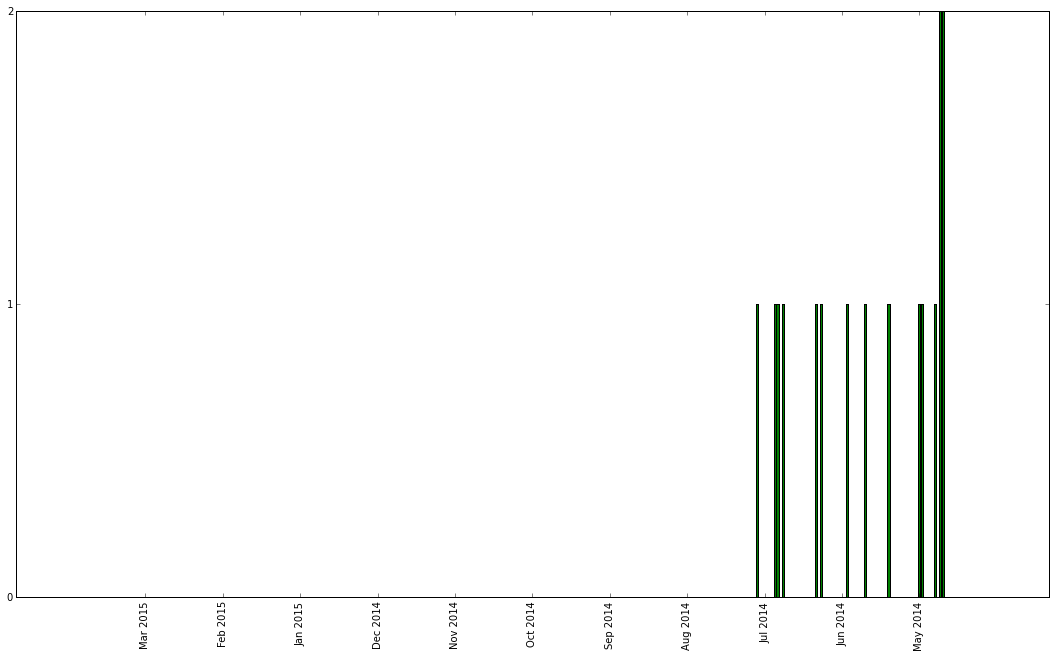

In [32]:
plot_doc_freq_bar_chart(podemos_loaded_doc_dict, 'green')

In [ ]:
# Mètode per descarregar els documents del diccionari de docs de Podemos
def download_podemos_docs(podemos_doc_dict, path="", overwrite=False):
    for key in podemos_doc_dict:
        if podemos_doc_dict[key]['file']=="" or overwrite:
            if podemos_doc_dict[key]['type'] == 'html':
                html_page = get_html_page(podemos_doc_dict[key]['url'])
                if html_page:
                    print "Parsing: " + url_page
                else:
                    continue

                soup = BeautifulSoup(html_page)
                div_struct_txt = soup.find('div', {'id' : 'struct_txt'})
                if div_struct_txt:
                    # Neteja del doc eliminant parts
                    div_share = div_struct_txt.find('div', {'class' : 'articles_txt_share_bottom_box'})
                    div_share.extract()
                    div_left = div_struct_txt.find('div', {'class' : 'left_nav'})
                    div_left.extract()
                    print "Saving: ", podemos_doc_dict[key]['url']
                    # print div_struct_txt
                    filename = del_invalid_chars(podemos_doc_dict[key]['name'] + '.html', invalid_filename_chars_windows)
                    save_text_file(div_struct_txt, path + filename)
                    podemos_doc_dict[key]['file'] = path + filename
                else:
                    print "ERROR: No trobat detall del doc: " + url_page
            elif podemos_doc_dict[key]['type'] == 'pdf':
                print "Saving: ", podemos_doc_dict[key]['url']
                file_name = psoe_doc_dict[key]['url'].split('/')[-1]
                download_file(podemos_doc_dict[key]['url'], file_name, path)
                podemos_doc_dict[key]['file'] = path + filename
            else:
                print "Unknown file type to download:", podemos_doc_dict[key]['type']
            
    print "Updating 'podemos_doc_dict'..."
    save_dict_json(podemos_doc_dict, 'podemos_doc_dict.json')
    
download_podemos_docs(podemos_loaded_doc_dict, '../data/podemos/')

## Saving parsed docs to MongoDB [ under construction...   ^__^  ]

In [ ]:
import pymongo

# Connection to Mongo DB
try:
    conn=pymongo.MongoClient()
    print "Connected successfully!!!"
except pymongo.errors.ConnectionFailure, e:
   print "Could not connect to MongoDB: %s" % e 
conn
print conn.database_names()


In [ ]:
db = conn['crawlerDB']
print db.collection_names()
collection = db['http://hunch.netDB']

In [ ]:
print collection.count()

for d in collection.find():
    print d

In [ ]:
collection.find({"date":"16/10/2014"}).count()

In [ ]:
collection.find({"date":{"$gte":"01/01/2014"}}).count()